In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Bernoulli

import numpy as np
from tools import *
from distributions import *
from utils import *
import operator
import itertools
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
np.random.seed(0)
torch.manual_seed(0)
opt= {}
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    opt['device']= torch.device('cuda:0')
    opt['if_cuda']=True
else:
    opt['device']= torch.device('cpu')
    opt['if_cuda']=False

In [ ]:
class conv_encoder(nn.Module):
    def __init__(self, opt):
        super().__init__()
        self.z_dim=opt['z_dim']
        self.x_dim=opt['x_dim']
        kernels=[9,7,7,5]
        chans=[8,32,128,256]
        self.act=F.relu

        self.rec1 = nn.Conv2d(in_channels=1, out_channels=chans[0], kernel_size=kernels[0])
        self.rbn1 = nn.BatchNorm2d(chans[0])

        self.rec2 = nn.Conv2d(in_channels=chans[0], out_channels=chans[1], kernel_size=kernels[1])
        self.rbn2 = nn.BatchNorm2d(chans[1])

        self.rec3 = nn.Conv2d(in_channels=chans[1], out_channels=chans[2], kernel_size=kernels[2])
        self.rbn3 = nn.BatchNorm2d(chans[2])

        self.rec4 = nn.Conv2d(in_channels=chans[2], out_channels=chans[3], kernel_size=kernels[3])
        self.rbn4 = nn.BatchNorm2d(chans[3])

        self.en_fc1 = nn.Linear(4096, 512)
        self.rbn5 = nn.BatchNorm1d(512)
        self.en_fc2_1 = nn.Linear(512, self.z_dim)
        self.en_fc2_2 = nn.Linear(512, self.z_dim)

    def forward(self, x):
        x=x.view(-1,1,28,28)
        h = self.act(self.rbn1(self.rec1(x)))
        h = self.act(self.rbn2(self.rec2(h)))
        h = self.act(self.rbn3(self.rec3(h)))
        h = self.act(self.rbn4(self.rec4(h)))
        h=h.view(-1,4096)
        h = self.rbn5(self.en_fc1(h))
        mu = self.en_fc2_1(h)
        std=torch.exp(self.en_fc2_2(h))
        return mu, std

    
class conv_decoder(nn.Module):
    def __init__(self, opt):
        super().__init__()
        self.z_dim=opt['z_dim']
        self.x_dim=opt['x_dim']
        kernels=[9,7,7,5]
        chans=[8,32,128,256]
        self.act=F.relu
        
        self.de_fc1 = nn.Linear(self.z_dim, 512)
        self.rbn1_ff = nn.BatchNorm1d(512)
        self.de_fc2 = nn.Linear(512, 4096)
        self.rbn2_ff = nn.BatchNorm1d(4096)

        self.rec1 = nn.ConvTranspose2d(in_channels=chans[3], out_channels=chans[2], kernel_size=kernels[3])
        self.rbn1 = nn.BatchNorm2d(chans[2])

        self.rec2 = nn.ConvTranspose2d(in_channels=chans[2], out_channels=chans[1], kernel_size=kernels[2])
        self.rbn2 = nn.BatchNorm2d(chans[1])

        self.rec3 = nn.ConvTranspose2d(in_channels=chans[1], out_channels=chans[0], kernel_size=kernels[1])
        self.rbn3 = nn.BatchNorm2d(chans[0])

        self.rec4 = nn.ConvTranspose2d(in_channels=chans[0], out_channels=1, kernel_size=kernels[0])


    def forward(self, z, if_sigmoid=True):
        h=self.act(self.rbn1_ff(self.de_fc1(z)))
        h=self.act(self.rbn2_ff(self.de_fc2(h)))
        h=h.view(-1,256,4,4)
        h=self.act(self.rbn1(self.rec1(h)))
        h = self.act(self.rbn2(self.rec2(h)))
        h = self.act(self.rbn3(self.rec3(h)))
        x = self.rec4(h)
        return x.view(-1,784)

In [2]:
class vae(nn.Module):
    def __init__(self,opt):
        super(vae, self).__init__()
        self.z_dim=10
        self.log_scale=torch.nn.Parameter(torch.Tensor([0.]))
        self.en_fc1 = nn.Linear(784, 600)
        self.en_fc2 = nn.Linear(600, 400)
        self.en_fc3 = nn.Linear(400, 200)
        self.en_fc4_1 = nn.Linear(200, self.z_dim)
        self.en_fc4_2 = nn.Linear(200, self.z_dim)
        self.de_fc1 = nn.Linear(self.z_dim, 200)
        self.de_fc2 = nn.Linear(200, 400)
        self.de_fc3 = nn.Linear(400, 600)
        self.de_fc4_1 = nn.Linear(600, 784)
        self.de_fc4_2 = nn.Linear(600, 784)
        
        self.device=opt['device']
        self.if_cuda=opt['if_cuda']
        self.prior_mu=torch.zeros(self.z_dim, requires_grad=False)
        self.prior_std=torch.ones(self.z_dim, requires_grad=False)
        self.params = list(self.parameters())
        self.optimizer = optim.Adam(self.params, lr=1e-4)


    def posterior(self, x):
        h = F.leaky_relu(self.en_fc1(x))
        h = F.leaky_relu(self.en_fc2(h))
        h = F.leaky_relu(self.en_fc3(h))
        mu = self.en_fc4_1(h)
        log_std = self.en_fc4_2(h)
        return mu, torch.exp(log_std)


    def model(self, z):
        h = F.leaky_relu(self.de_fc1(z))
        h = F.leaky_relu(self.de_fc2(h))
        h = F.leaky_relu(self.de_fc3(h))
        mean = self.de_fc4_1(h)
        log_scale=torch.ones_like(mean)*self.log_scale
#         log_scale=self.de_fc4_2(h)*0+torch.log(torch.tensor(0.1))
        return mean.clamp(min=-0.5 + 1. / 512., max=0.5 - 1. / 512.),log_scale
    
    def loss(self,x):
        z_mu, z_std=self.posterior(x)
        eps = torch.randn_like(z_mu).to(self.device)
        z=eps.mul(z_std).add_(z_mu)
        mean,log_scale=self.model(z)
        l = discretized_logistic_logp(mean,log_scale,x)
        kl=batch_KL_diag_gaussian_std(z_mu,z_std,self.prior_mu.to(self.device),self.prior_std.to(self.device))
        loss= torch.mean(-l+kl,dim=0)/np.log(2.0)
        bpd=loss/784.
        return loss,bpd
    
        
    def sample(self,n=100):
        with torch.no_grad():
            z = torch.randn(n, self.z_dim).to(self.device)
            x_mean,x_scale=self.model(z)
            return x_mean.clamp(min=-0.5 + 1. / 512., max=0.5 - 1. / 512.)+0.5

In [3]:
train_data=torchvision.datasets.MNIST('../dataset/', train=True, download=False,transform=torchvision.transforms.ToTensor())
train_data_list=[]
for x,y in train_data:
    x=torch.clamp(x,1. / 512.,1-1. / 512.)-0.5
    train_data_list.append(x)

epoch 10
loss 7136.76025390625


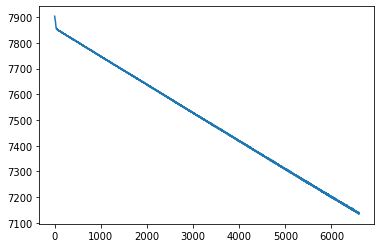

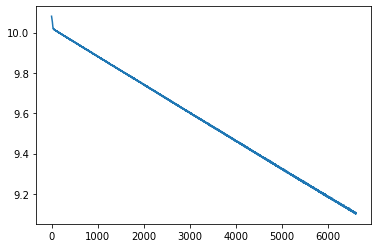

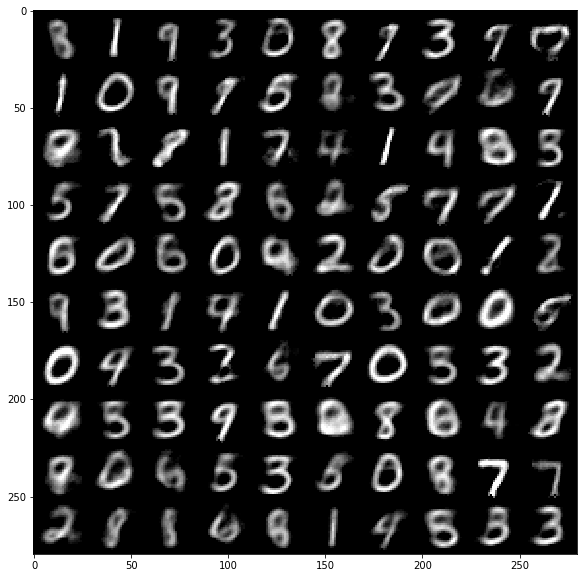

epoch 20
loss 6512.2197265625


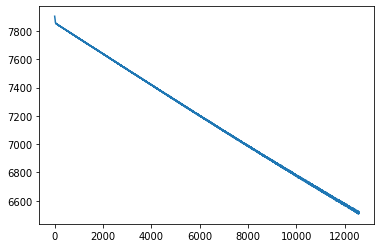

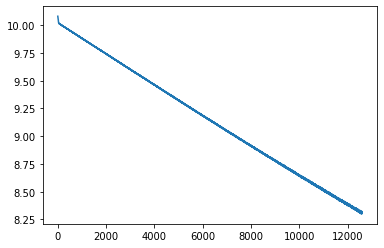

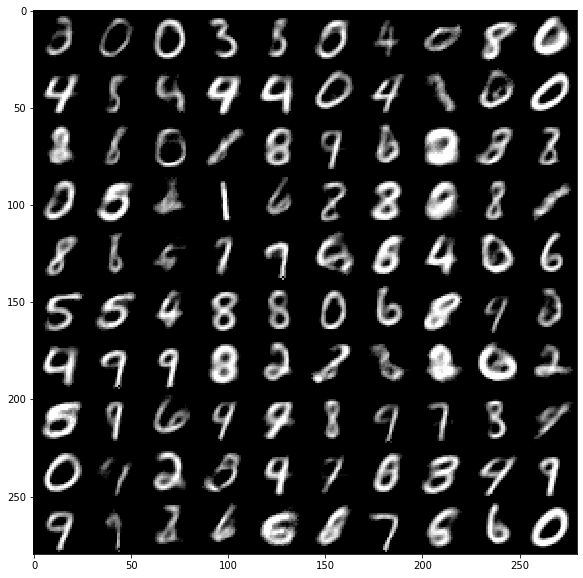

epoch 30
loss 5946.7080078125


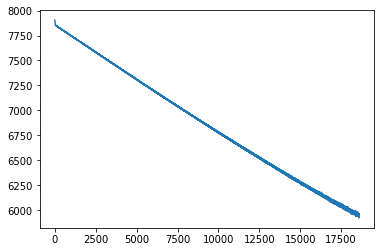

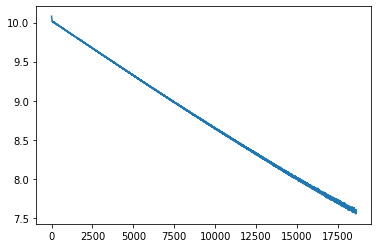

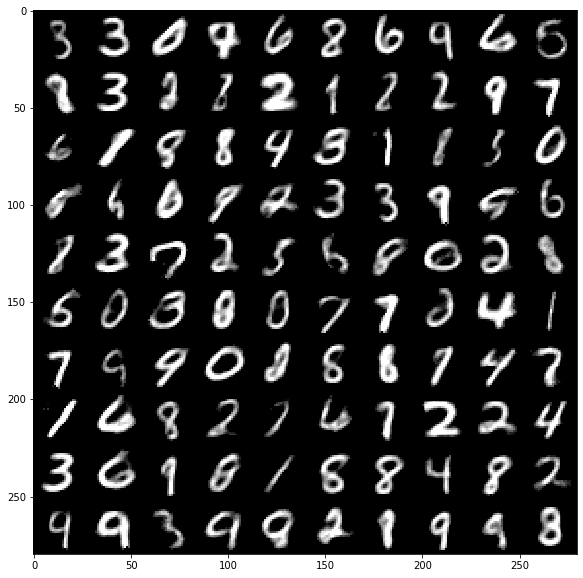

epoch 40
loss 5451.4072265625


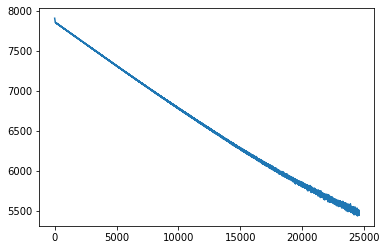

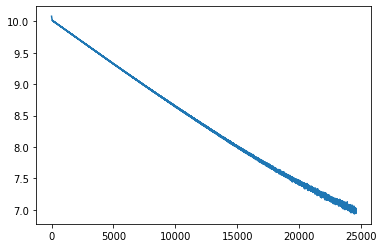

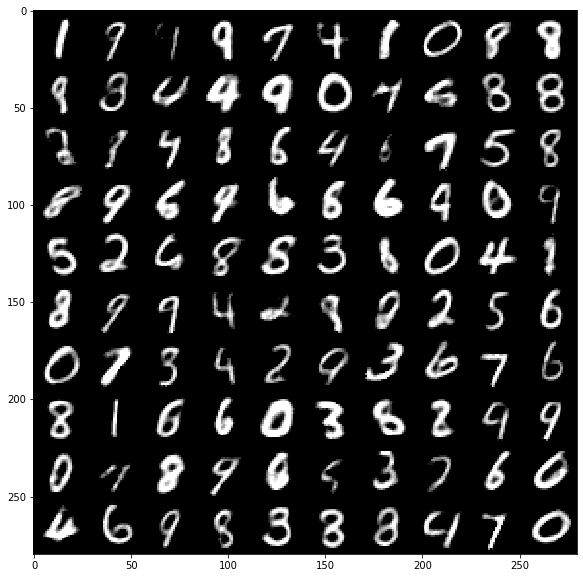

epoch 50
loss 5010.275390625


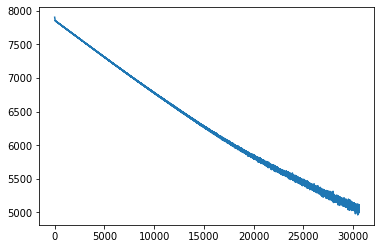

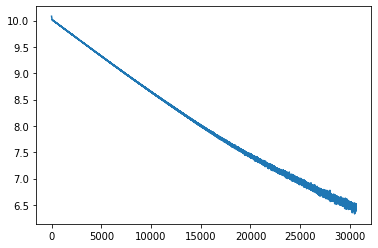

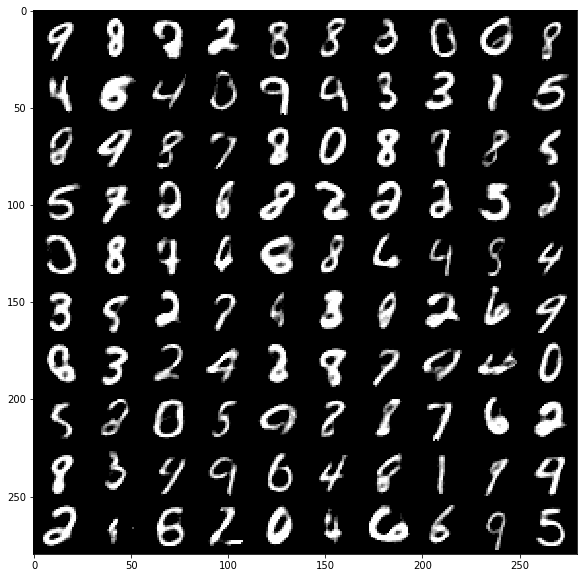

epoch 60
loss 4648.25732421875


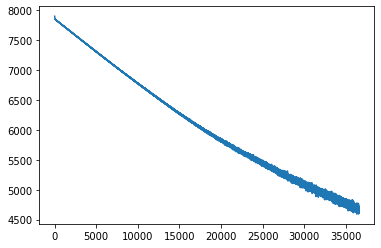

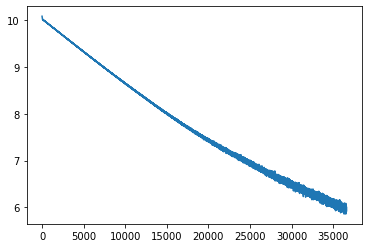

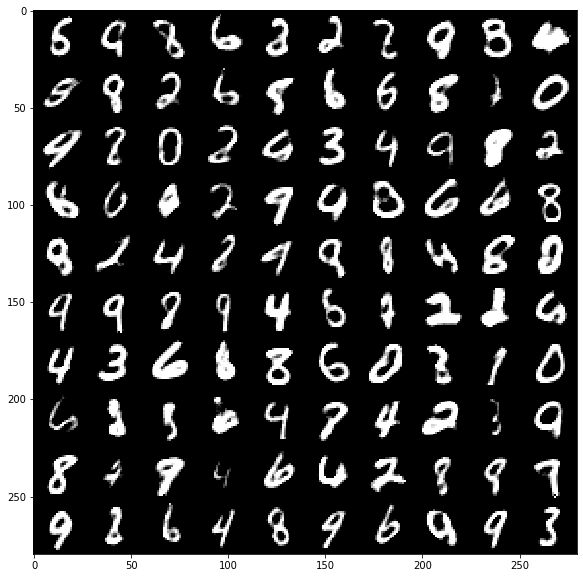

epoch 70
loss 4320.43994140625


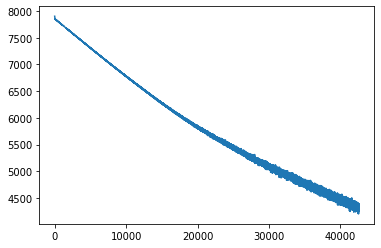

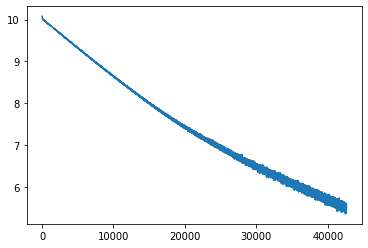

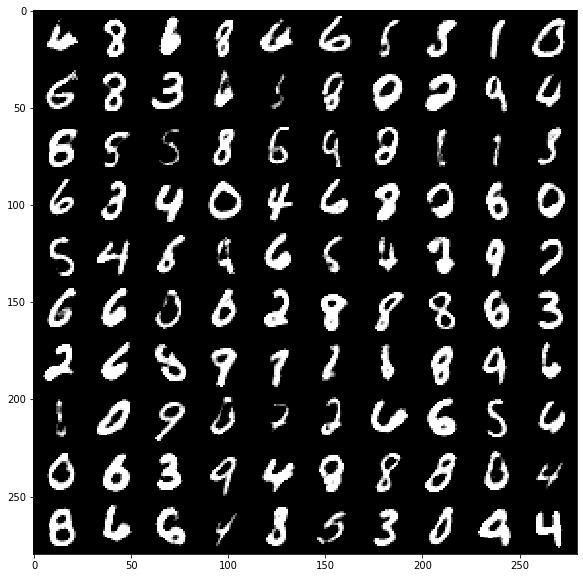

epoch 80
loss 3943.60693359375


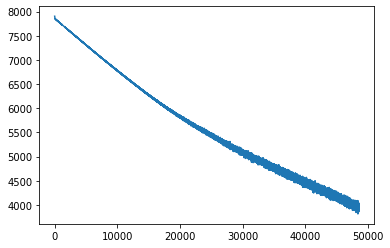

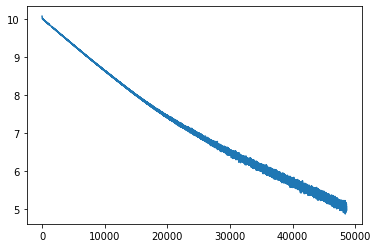

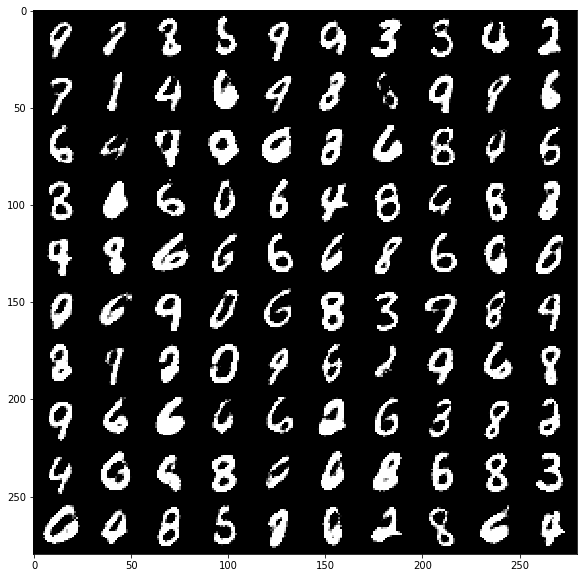

epoch 90
loss 3575.357666015625


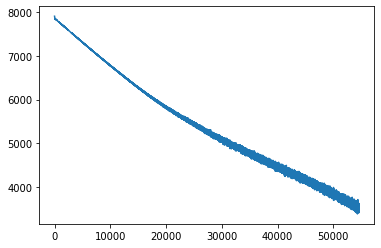

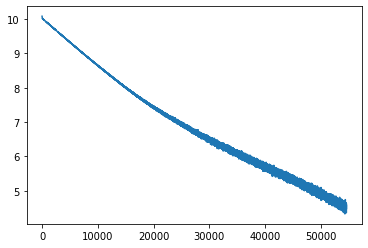

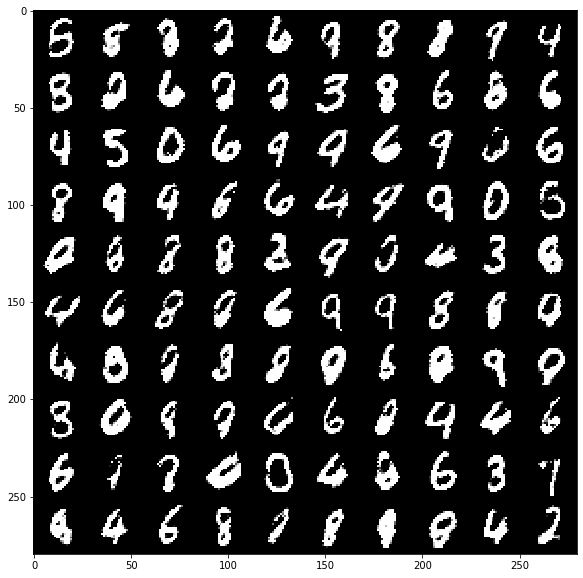

epoch 100
loss 3245.588623046875


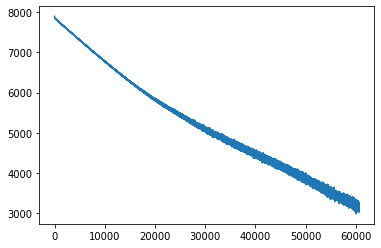

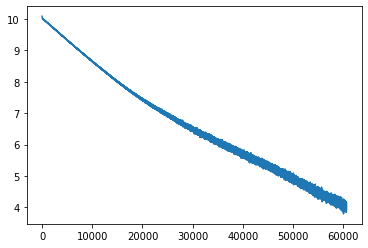

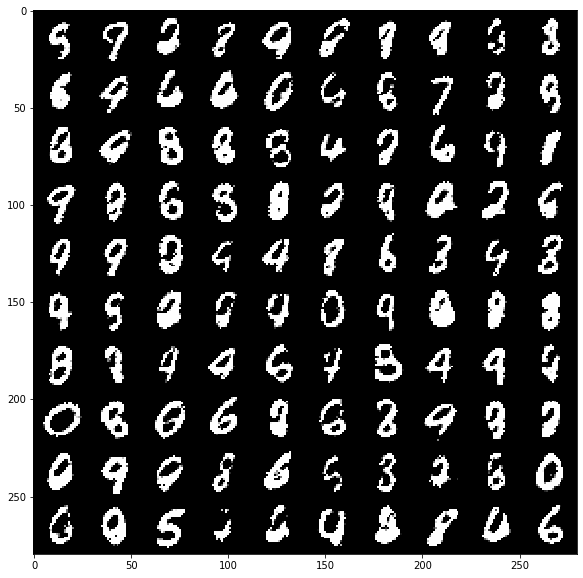

epoch 110
loss 2977.676025390625


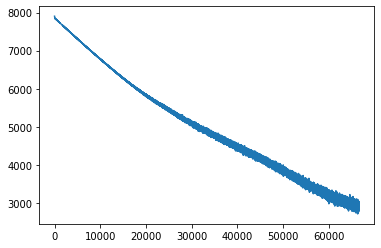

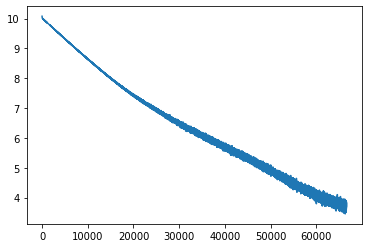

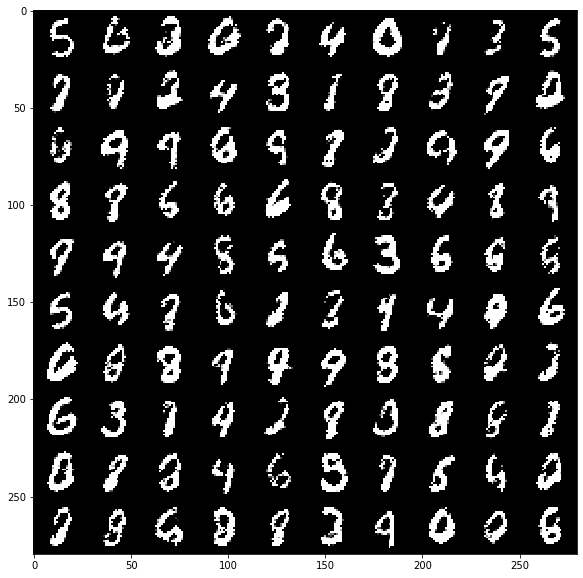

epoch 120
loss 2867.13037109375


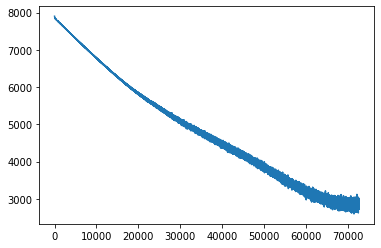

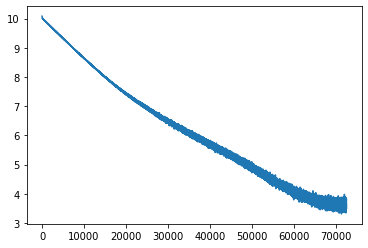

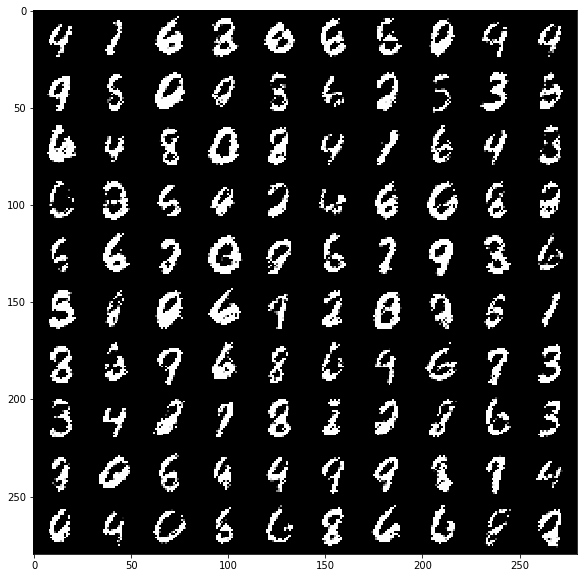

epoch 130
loss 2873.786376953125


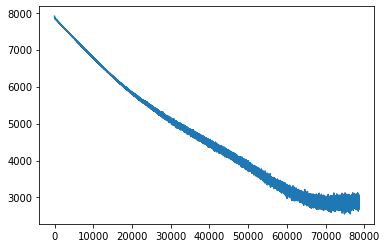

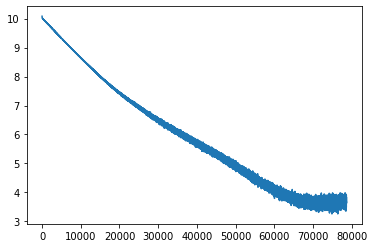

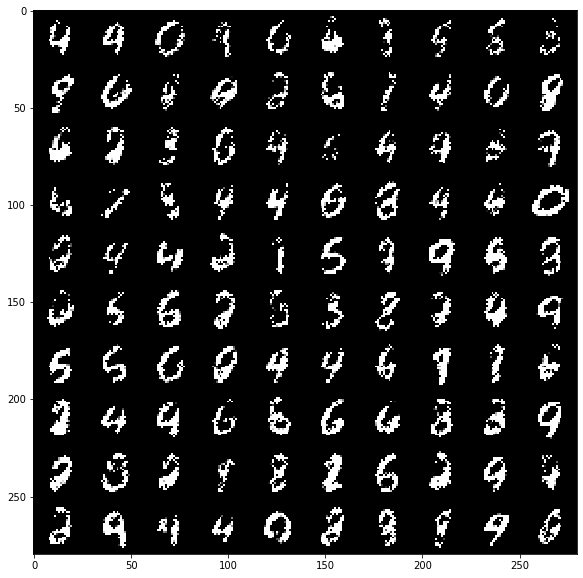

epoch 140
loss 2741.211669921875


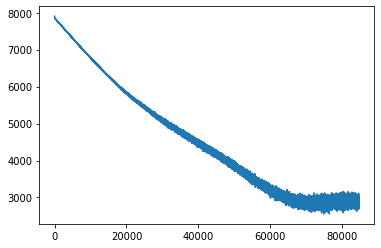

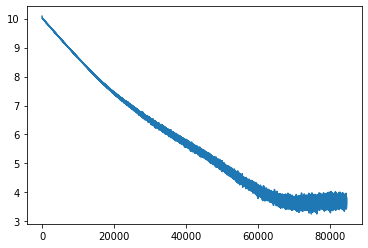

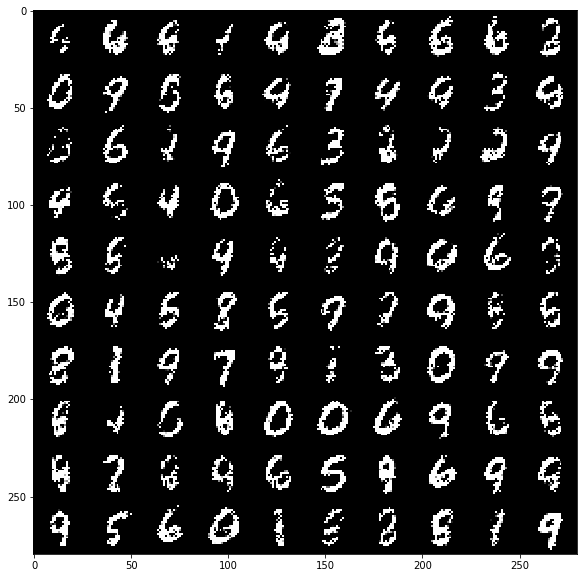

epoch 150
loss 2865.763671875


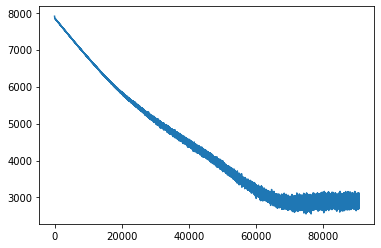

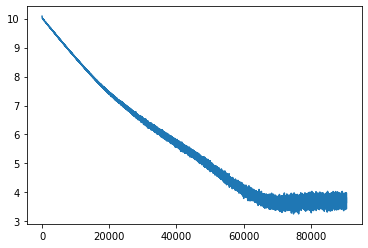

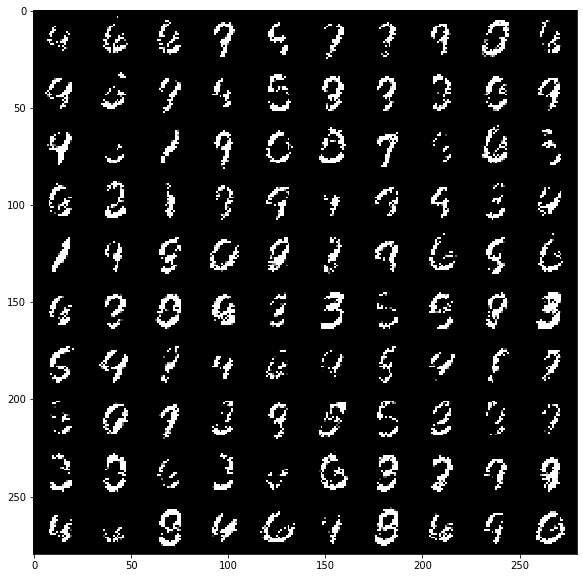

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-ecab6e8bd323>", line 15, in <module>
    loss.backward()
  File "/usr/local/lib/python3.7/site-packages/torch/tensor.py", line 166, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph)
  File "/usr/local/lib/python3.7/site-packages/torch/autograd/__init__.py", line 99, in backward
    allow_unreachable=True)  # allow_unreachable flag
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occu

KeyboardInterrupt: 

In [4]:
vae_model = vae(opt).to(opt['device'])
loss_list=[]
bpd_list=[]
for epoch in range(0,1000):
    if epoch>500:
        if epoch%50==0:
            lr=0.0001/(epoch/100)
            vae_model.optimizer = optim.Adam(vae_model.params, lr)
    for i in range(0,600):
        index=np.random.choice(60000,100)
        batch_data_list=[train_data_list[i] for i in index]
        batch_data=torch.stack(batch_data_list).view(-1,784).to(opt['device'])
        vae_model.optimizer.zero_grad()
        loss,bpd = vae_model.loss(batch_data)
        loss.backward()
        loss_list.append(loss.item())
        bpd_list.append(bpd.item())
        vae_model.optimizer.step()
    if epoch%10==0 and epoch!=0:
        print('epoch',epoch)
        print('loss',loss.item())
        plt.plot(loss_list)
        plt.show()
        plt.plot(bpd_list)
        plt.show()
        
        x_sample=vae_model.sample()
        show_many(x_sample,10)
        torch.save(vae_model.state_dict(), './model_save/vae.pth')

In [6]:
print(torch.exp(vae_model.log_scale))

tensor([0.0007], grad_fn=<ExpBackward>)


In [ ]:
z_mu, z_std=vae_model.posterior(batch_data)
eps = torch.randn_like(z_mu).to(vae_model.device)
z=eps.mul(z_std).add_(z_mu)
mean,log_scale=vae_model.model(z)
print(mean)
# l = discretized_logistic_logp(mean,log_scale,x)
# kl=batch_KL_diag_gaussian_std(z_mu,z_std,self.prior_mu.to(self.device),self.prior_std.to(self.device))
# loss= torch.mean(-l+kl,dim=0)

In [ ]:
with torch.no_grad():
    z = torch.randn(100, vae_model.z_dim)
    x_mean,x_scale=vae_model.model(z)
    uniform_noise=torch.clamp(torch.rand_like(x_mean),1e-7,1-1e-7)
    x_sample=x_mean + x_scale * (torch.log(uniform_noise) - torch.log(1-uniform_noise))
    x_sample=torch.floor(x_sample*256)/256
    show_many(x_mean,10)

In [ ]:
print(x_mean)

In [ ]:
# test_data=torchvision.datasets.MNIST('../dataset/', train=False, download=False,transform=torchvision.transforms.ToTensor())
# test_data_list=[]
# for x,y in test_data:
#     test_data_list.append(np.rint(x))
    
# vae_model = vae(opt).to(opt['device'])
# # vae_model.load_state_dict(torch.load("./model_save/binary_vae.pth"))